In [ ]:
#!pip3 install opencv-python
#!pip install pafy
#!pip install youtube_dl

# ImageWidget

In [425]:
import cv2
import numpy as np
from PIL import Image
import io

style = {'description_width': '250px'}
layout = {'width': '500px'}

class ImageWidget(object):
    def __init__(self, image=None, display=True):
        self.image_w = widgets.Image(format='PNG')
        self.setImage(image)
        if display == True:
            self.display()
    
    def display(self):
        display(self.image_w)  
    
    def getByteArray(self,image):    
        #return None
        img_byte_arr = io.BytesIO()
        image.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()
        return img_byte_arr
    
    def evaluate(self, image=None):
        self.setImage(image)
    
    def setImage(self,image):
        #print('ImageWidget')
        if image != None:
            try:
                #print('set image', type(image))
                if isinstance(image, dict):
                    image = image['image']
                self.image_w.value = self.getByteArray(image)    
            except Exception as exception: 
                print('Exception ImageWidget', str(exception))
            
    def getImage(self):
        return Image.open(io.BytesIO(self.image_w.value))

# BaseAction

In [2]:
class BaseAction(object):
    
    def dict(self):
        return {'class' : self.__class__.__name__, 'parameters' : self.__dict__}
    
    def merged_dict(self,parameters=None):
        old = dict()
        return {'class':old['class'],'parameters':{**old['parameters'],**parameters}}
    
    def merge(self,parameters={}):
        adict = {'class' : self.__class__.__name__, 'parameters' : {**self.__dict__, **parameters}}
        #adict = merged_dict(parameters)
        return eval(adict['class'])(**adict['parameters'])

# CropAction

In [636]:
# input: image, output cropped image
class CropAction(BaseAction):
    WORLD = 0
    NORMALIZED = 1
    # __init__ is a special method called whenever you try to make
    # an instance of a class. As you heard, it initializes the object.
    # Here, we'll initialize some of the data.
    #def __init__(self, image=None, size=None, min=[0.0,0.0], max=[1.0,1.0]):
    def __init__(self,size=None, min=None, max=None,mode=WORLD):
        self.min  = min
        self.max  = max
        self.size = size
        self.mode = mode
        
    def dict(self):
        # return self.toNormalized().super(CropAction,self).__init__().dict()
        #return self.toNormalized().dict()
        return super(CropAction, self.toNormalized()).dict()
        
    # Problem: + 1    
    def evaluate(self, image=None):
        if self.mode == self.WORLD:
            return {'image':image.crop(self._flat())}
        return {'image':image.crop(self.fromNormalized(self.flat(), size=image.size))}      
        
    def _flat(self):
        return (self.min[0],self.min[1],self.max[0] + 1,self.max[1] + 1)
    
    def flat(self):
        return (self.min[0],self.min[1],self.max[0],self.max[1])
    
    def normalizeValue(self, value, size):
        return float (value) / size

    def fromNormalizedValue(self, value,size):
        return int(value * size)

    def normalized(self):    
        #print(self.min, self.max, self.size)
        xmin = self.normalizeValue(self.min[0],self.size[0])
        ymin = self.normalizeValue(self.min[1],self.size[1])
        xmax = self.normalizeValue(self.max[0],self.size[0])
        ymax = self.normalizeValue(self.max[1],self.size[1])
        return (xmin,ymin,xmax,ymax)    

    def toNormalized(self):
        if self.mode == self.NORMALIZED:
            return self
        _norm = self.normalized()
        return CropAction(min=[_norm[0],_norm[1]], max=[_norm[2],_norm[3]], mode=self.NORMALIZED)
    
    def toWorld(self,size):
        if self.mode == self.WORLD:
            return self
        _world = self.fromNormalized(self.flat(),size=size)
        return CropAction(min=[_world[0],_world[1]], max=[_world[2],_world[3]], size=size, mode=self.WORLD)
    
    def fromNormalized(self, values, size=None):    
        if size == None:
            size = self.size
             
        # init size to fix initMinMax problem --> is this really required
        self.size = size        
                
        #print('fromNormalized',size)        
        xmin = self.fromNormalizedValue(values[0],size[0])
        ymin = self.fromNormalizedValue(values[1],size[1])
        xmax = self.fromNormalizedValue(values[2],size[0])
        ymax = self.fromNormalizedValue(values[3],size[1])
        return [xmin,ymin,xmax,ymax]
    
    def update(self, size=None):
        self.size = size
        to = self.normalized()
        self.min[0] = self.fromNormalizedValue(to[0],size[0])
        self.min[1] = self.fromNormalizedValue(to[1],size[1])
        self.max[0] = self.fromNormalizedValue(to[2],size[0]) 
        self.max[1] = self.fromNormalizedValue(to[3],size[1]) 

# DisplayWidget

In [499]:
class DisplayWidget():
    def __init__(self, action=None, update=None):
        self.action       = action
        self.vstreams     = None
        self.index        = 0
        self.image        = None
        #self.parent       = parent
        self.update       = update
        
        _max = 5
        self.imageselectw = widgets.IntSlider(value=0, min=0,max=_max,step=1, description='image',layout=layout)
        self.imageselectw.observe(self.on_value_change_imageselectw, 'value')
        self.next_image_button = widgets.Button(description='Next', disabled=False, tooltip='next image',style=style)
        self.next_image_button.on_click(self.on_next_image_button_clicked)  
        self.skipframes = widgets.Text(description   = 'skip frames',value = '10', style=style, layout=layout)
        image_select_hbox = widgets.HBox([self.imageselectw,self.next_image_button,self.skipframes])
        self.hbox=image_select_hbox
        
        if action != None:
            self.init(action)
        
    def init(self,action):
        self.action = action
        self.vstreams = action.getVstreams() 
        #self.updateImage()
    
    # select image slider
    def on_value_change_imageselectw(self,change):
        self.index = change['new']
        self.action.setIndex(change['new'])
        self.image = self.vstreams[self.index] 
        self.update(self.image)
        
    def on_next_image_button_clicked(self,b):
        if self.action.index != self.index:
            self.action = VideoAction(video=self.action.video,index=self.index)
        self.action.skipframes = int(self.skipframes.value)
        self.image = self.action.evaluate()['image']
        #self.parent.crop_image()
        self.update(self.image)

In [ ]:
class DisplayWidget0():
    def __init__(self, action=None, imageWidget=None):
        # VideoAction
        self.action       = action
        self.vstreams     = None
        self.index        = 0
        self.imageWidget  = imageWidget
        self.image        = None
        
        _max = 5
        self.next_image_button = widgets.Button(description='Next', disabled=False, tooltip='next image',style=style)
        self.next_image_button.on_click(self.on_next_image_button_clicked)  
        self.skipframes = widgets.Text(description   = 'skip frames',value = '10', style=style, layout=layout)
        image_select_hbox = widgets.HBox([self.next_image_button,self.skipframes])
        self.hbox=image_select_hbox
        
        # select image slider

    def on_next_image_button_clicked(self,b):
        #global vstreams
        #_video   = self.videoAction.video
        if self.action.index != self.index:
            self.action = VideoAction(video=self.action.video,index=self.index)
        self.action.skipframes = int(self.skipframes.value)
        #self.image = self.action.readImage()
        self.image = self.action.evaluate()
        self.imageWidget.setImage(self.image)
        
    def updateImage(self):
        #newimage = getVstream(vstreams=self.vstreams, index=index)   
        self.image = self.vstreams[self.index]   
        #newsize = newimage.size
        #self.action.update(newsize)
        self.imageWidget.setImage(self.image)
        #self.initMinMax(self.action.size,self.action.flat())
        #self.initMinMax()
        #crop_image() 

# OLD CropWidget

In [5]:
class CropWidget():
    def __init__(self, action=None, parent=None, imageWidget=None, image=None, vstreams=None):
        self.image         = image
        self.result        = {'image':image} 
        self.action       = action
        self.videoAction  = None
        self.parent       = None
        self.imageWidget  = imageWidget
        self.vstreams     = vstreams
        self.index        = 0
        
        cropNormalizedArea = [0.0,0.0,1.0,1.0]    
        self.regions = dict()
        self.regions['reset'] = cropNormalizedArea
    
        if image != None:
            action.size = image.size
    
        self.reset_button = widgets.Button(description='Reset', disabled=False, tooltip='reset all values',style=style)
        self.reset_button.on_click(self.on_reset_button_clicked)  

        self.crop_name = widgets.Text(description = 'name',value = '', style=style, layout=layout,disabled=False)
        self.crop_name.on_submit(self.on_value_submit_crop_name)
        self.crop_list = widgets.Dropdown(description='region',options=self.regions.keys())
        self.crop_list.observe(self.crop_list_on_change) 
        self.crop_bookmarks = widgets.HBox([self.crop_list, self.crop_name, self.reset_button])

        _max = len(vstreams)
        if _max > 0:
            _max = _max -1
        self.imageselectw = widgets.IntSlider(value=0, min=0,max=_max,step=1, description='image',layout=layout)
        self.imageselectw.observe(self.on_value_change_imageselectw, 'value')
        self.next_image_button = widgets.Button(description='Next', disabled=False, tooltip='next image',style=style)
        self.next_image_button.on_click(self.on_next_image_button_clicked)  
        image_select_hbox = widgets.HBox([self.imageselectw,self.next_image_button])
        
        #self.cropx0 = self._IntSlider(description='x0',value=0)
        #self.cropx1 = self._IntSlider(description='x1')
        #self.cropx0 = widgets.IntSlider(value=0, step=1, description='x0',layout=layout)
        #self.cropx1 = widgets.IntSlider(value=0, step=1, description='x1',layout=layout)
        #self.cropx0.observe(self.on_value_change_crop_xmin, 'value')
        #self.cropx1.observe(self.on_value_change_crop_xmax, 'value')
        
        #self.crop_hbox_x = widgets.HBox([self.cropx0, self.cropx1])
        
        self.crop_hbox_x = widgets.HBox()
        self.crop_hbox_y = widgets.HBox()
        self._addIntCropSliders()
        
        #self.crop_hbox_y = widgets.HBox([self.cropy0, self.cropy1])
        
        self.vbox   = widgets.VBox([image_select_hbox,self.crop_bookmarks,self.crop_hbox_x, self.crop_hbox_y])
        #display(self.crop_vbox)
        #self.imageWidget.display()
        
        if action != None:
            self.initMinMax(action.size,(0,0,action.size[0]-1,action.size[1]-1))
        
    def _addIntCropSliders(self):
        self.cropx0 = self._IntSlider(description='x0')
        self.cropx1 = self._IntSlider(description='x1')
        self.cropx0.observe(self.on_value_change_crop_xmin, 'value')
        self.cropx1.observe(self.on_value_change_crop_xmax, 'value')
        self.crop_hbox_x.children = (self.cropx0,self.cropx1)
        
        self.cropy0 =  self._IntSlider(description='y0')
        self.cropy1 =  self._IntSlider(description='y1')
        self.cropy0.observe(self.on_value_change_crop_ymin, 'value')
        self.cropy1.observe(self.on_value_change_crop_ymax, 'value')
        self.crop_hbox_y.children = (self.cropy0,self.cropy1)
        
    def _FloatSlider(self,description='',value=0.0,layout=layout):
        return widgets.FloatSlider(value=value,description=description, min=0, max=1.0, step=0.001, readout_format='.3f',layout=layout)
    
    def _IntSlider(self,description='',value=0,max=0,layout=layout):
        return widgets.IntSlider(value=value, max=max,step=1, description=description,layout=layout)    
        
    # INIT    
    def init(self, action=None, parent=None):
        self.videoAction = action
        self.vstreams = action.getVstreams()
        self.image    = self.vstreams[0]
        
        self.action   = CropAction(size=self.image.size,min=[0,0], max=[self.image.size[0],self.image.size[1]])
        self.initMinMax()
        self.imageselectw.max = len(self.vstreams) - 1
        self.imageWidget.setImage(self.image) 
        self.parent = parent
        self.crop_list.options=self.parent.sources.videos[self.parent.id]['bookmarks'].keys()
        
    # RESULT 
    def crop_image(self):
        #return
        #print(self.image.size)
        self.result = self.action.evaluate(image=self.image)
        #print(cropped_image.size)
        self.imageWidget.setImage(self.result['image'])    
        
        
    def initMinMax(self,size=None,cropArea = None):
        if self.action == None:
            return
        
        if size == None:
            size = self.action.size
            cropArea = self.action.flat()
        
        self.cropx0.max = size[0] - 1
        self.cropx1.max = size[0] - 1
        self.cropy0.max = size[1] - 1
        self.cropy1.max = size[1] - 1

        self.cropx0.value = cropArea[0]
        self.cropy0.value = cropArea[1]
        self.cropx1.value = cropArea[2]
        self.cropy1.value = cropArea[3]    
        
    def on_value_change_crop_xmin(self,change):
        #print(type(change['new']))
        self.cropx1.min  = change['new']
        self.action.min[0] = change['new']
        self.crop_image()
            
    def on_value_change_crop_xmax(self,change):
        #print(change['new'],self.action.max)
        self.cropx0.max  = change['new']
        self.action.max[0] = change['new']
        self.crop_image()

    def on_value_change_crop_ymin(self,change):
        self.cropy1.min  = change['new']
        self.action.min[1] = change['new']
        self.crop_image()

    def on_value_change_crop_ymax(self,change):
        self.cropy0.max  = change['new']
        self.action.max[1] = change['new']
        self.crop_image()        
        
    # new bookmark event
    def on_value_submit_crop_name(self,change):
        #print(change)
        self.parent.sources.videos[self.parent.id]['bookmarks'][change.value] = self.action.normalized()
        #self.regions[change.value] = self.action.normalized()
        if change.value not in self.crop_list.options:
            self.crop_list.options = list(self.crop_list.options) + [change.value] 
        #(cropArea,image.size)
        #print(list(self.crop_list.options),self.crop_list.value, change.value)
        self.crop_list.value = change.value
        
    def crop_list_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            #print(self.regions[change['new']])
            #initMinMax(image.size,bookmark_dict[change['new']])
            #values = fromNormalizedMinMax(bookmark_dict[change['new']],image.size)
            #initMinMax(image.size,values)
            self.crop_name.value = change['new']
            #print('init',self.action.size,self.regions[change['new']])
            #self.initMinMax(self.action.size,self.action.fromNormalized(self.regions[change['new']]))
            self.initMinMax(self.action.size,self.action.fromNormalized(self.parent.sources.videos[self.parent.id]['bookmarks'][change['new']]))
            #self.initMinMax()

    def on_reset_button_clicked(self,b):
        #cropArea        = [0,0,image.size[0],image.size[1]]
        self.action.min = [0,0]
        self.action.max = [self.image.size[0],self.image.size[1]]
        self.initMinMax()
        self.crop_name.value = ''
        #crop_list.value = ''

    def updateImage(self,index):
        #newimage = getVstream(vstreams=self.vstreams, index=index)   
        newimage = self.vstreams[index]   
        newsize = newimage.size
        self.action.update(newsize)
        self.image = newimage
        #self.initMinMax(self.action.size,self.action.flat())
        self.initMinMax()
        #crop_image() 

    # select image slider
    def on_value_change_imageselectw(self,change):
        #imageselectw.disabled=True
        #global index
        self.index = change['new']
        self.updateImage(self.index)
        #imageselectw.disabled=False    

    def on_next_image_button_clicked(self,b):
        #global vstreams
        _video   = self.videoAction.video
        if self.videoAction.index != self.index:
            self.videoAction = VideoAction(video=_video,index=self.index)
        _vaction = self.videoAction
        self.image = _vaction.readImage()
        
        self.initMinMax()
        self.crop_image()
        #self.imageWidget.setImage(self.image)
        
        #self.initMinMax(self.action.size,self.action.fromNormalized(self.parent.sources.videos[self.parent.id]['bookmarks'][change['new']]))
        #self.vstreams = getVstreams(video=_video, indexes=[self.index])
        #self.updateImage(self.index)

#cropWidget = CropWidget(action=CropAction(size=image.size, min=[0,0], max=list(image.size)),imageWidget=ImageWidget(), image=image, vstreams=vstreams)   
#cropWidget = CropWidget(action=CropAction(),imageWidget=ImageWidget())


# CropWidget

In [637]:
#display(DisplayWidget(action=_crop.videoAction,imageWidget=_imageWidget).hbox)
class CropWidget():
    def __init__(self, action=None, videoAction=None ,parent=None, imageWidget=None, image=None, vstreams=None):
        self.result        = None
        self.action       = action
        #self.videoAction  = videoAction
        self.parent       = parent
        self.imageWidget  = imageWidget
        self.displayWidget = None
        
        cropNormalizedArea = [0.0,0.0,1.0,1.0]    
        self.regions = dict()
        self.regions['reset'] = cropNormalizedArea
    
        if image != None:
            action.size = image.size
    
        self.reset_button = widgets.Button(description='Reset', disabled=False, tooltip='reset all values',style=style)
        self.reset_button.on_click(self.on_reset_button_clicked)  

        self.crop_name = widgets.Text(description = 'name',value = '', style=style, layout=layout,disabled=False)
        self.crop_name.on_submit(self.on_value_submit_crop_name)
        self.crop_list = widgets.Dropdown(description='region',options=self.regions.keys())
        self.crop_list.observe(self.crop_list_on_change) 
        self.crop_bookmarks = widgets.HBox([self.crop_list, self.crop_name, self.reset_button])
        
        #self.cropx0 = self._IntSlider(description='x0',value=0)
        #self.cropx1 = self._IntSlider(description='x1')
        #self.cropx0 = widgets.IntSlider(value=0, step=1, description='x0',layout=layout)
        #self.cropx1 = widgets.IntSlider(value=0, step=1, description='x1',layout=layout)
        #self.cropx0.observe(self.on_value_change_crop_xmin, 'value')
        #self.cropx1.observe(self.on_value_change_crop_xmax, 'value')
        
        #self.crop_hbox_x = widgets.HBox([self.cropx0, self.cropx1])
        
        self.crop_hbox_x = widgets.HBox()
        self.crop_hbox_y = widgets.HBox()
        self._addIntCropSliders()
        
        self.vbox   = widgets.VBox([self.crop_bookmarks,self.crop_hbox_x, self.crop_hbox_y])
        
        if action != None and action.size != None:
            self.initMinMax(action.size,(0,0,action.size[0]-1,action.size[1]-1))
        
    def _addIntCropSliders(self):
        self.cropx0 = self._IntSlider(description='x0')
        self.cropx1 = self._IntSlider(description='x1')
        self.cropx0.observe(self.on_value_change_crop_xmin, 'value')
        self.cropx1.observe(self.on_value_change_crop_xmax, 'value')
        self.crop_hbox_x.children = (self.cropx0,self.cropx1)
        
        self.cropy0 =  self._IntSlider(description='y0')
        self.cropy1 =  self._IntSlider(description='y1')
        self.cropy0.observe(self.on_value_change_crop_ymin, 'value')
        self.cropy1.observe(self.on_value_change_crop_ymax, 'value')
        self.crop_hbox_y.children = (self.cropy0,self.cropy1)
        
    def _FloatSlider(self,description='',value=0.0,layout=layout):
        return widgets.FloatSlider(value=value,description=description, min=0, max=1.0, step=0.001, readout_format='.3f',layout=layout)
    
    def _IntSlider(self,description='',value=0,max=0,layout=layout):
        return widgets.IntSlider(value=value, max=max,step=1, description=description,layout=layout)    
        
    # INIT    
    def init(self, action=None, parent=None):
        self.parent = parent
        self.crop_list.options=self.parent.sources.videos[self.parent.id]['bookmarks'].keys()
        
        if self.displayWidget != None:
            self.displayWidget.init(action) 
        self.initMinMax()
          
    # after image is updated    
    def updateImage(self,image):
        size = image.size
        
        if(self.action == None):
            self.action   = CropAction(size=size,min=[0,0], max=[size[0],size[1]])
        
        # action can be normalized until size of image is known    
        if(self.action.mode != self.action.WORLD):
            self.action = self.action.toWorld(size=size)
            
        if(self.action.size != size):
            self.action.update(size)
            self.crop_image()
            self.initMinMax()
        else:
            self.crop_image()  
            
    # RESULT 
    def crop_image(self):
        
        if(self.displayWidget != None):  
            image = self.displayWidget.image
            
            if(self.action == None):
                self.action   = CropAction(size=image.size,min=[0,0], max=[image.size[0],image.size[1]])
            
            self.result = self.action.evaluate(image=image)
            
            if(self.imageWidget != None):
                self.imageWidget.setImage(self.result['image'])    
        
    def initMinMax(self,size=None,cropArea = None):
        if self.action == None:
            return
        
        if size == None:
            size = self.action.size
            cropArea = self.action.flat()
        
        self.cropx0.max = size[0] - 1
        self.cropx1.max = size[0] - 1
        self.cropy0.max = size[1] - 1
        self.cropy1.max = size[1] - 1

        self.cropx0.value = cropArea[0]
        self.cropy0.value = cropArea[1]
        self.cropx1.value = cropArea[2]
        self.cropy1.value = cropArea[3]    
        
    def on_value_change_crop_xmin(self,change):
        #print(type(change['new']))
        self.cropx1.min  = change['new']
        self.action.min[0] = change['new']
        self.crop_image()
            
    def on_value_change_crop_xmax(self,change):
        #print(change['new'],self.action.max)
        self.cropx0.max  = change['new']
        self.action.max[0] = change['new']
        self.crop_image()

    def on_value_change_crop_ymin(self,change):
        self.cropy1.min  = change['new']
        self.action.min[1] = change['new']
        self.crop_image()

    def on_value_change_crop_ymax(self,change):
        self.cropy0.max  = change['new']
        self.action.max[1] = change['new']
        self.crop_image()        
        
    # new bookmark event
    def on_value_submit_crop_name(self,change):
        self.parent.sources.videos[self.parent.id]['bookmarks'][change.value] = self.action.normalized()

        if change.value not in self.crop_list.options:
            self.crop_list.options = list(self.crop_list.options) + [change.value] 
        self.crop_list.value = change.value
        
    def crop_list_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            self.crop_name.value = change['new']
            self.initMinMax(self.action.size,self.action.fromNormalized(self.parent.sources.videos[self.parent.id]['bookmarks'][change['new']]))

    def on_reset_button_clicked(self,b):
        self.action.min = [0,0]
        self.action.max = [self.image.size[0],self.image.size[1]]
        self.initMinMax()
        self.crop_name.value = ''

# Resize

In [140]:
####################### scale
options={'NEAREST' : Image.NEAREST,'BOX' : Image.BOX,'BILINEAR' : Image.BILINEAR,'HAMMING' : Image.HAMMING,'BICUBIC' : Image.BICUBIC,'LANCZOS' : Image.LANCZOS}
#options={Image.NEAREST,Image.BOX,Image.BILINEAR,Image.HAMMING,Image.BICUBIC,Image.LANCZOS}
#size_options = {(128,128),(224,224),(240,240),(256,256),(299,299),(300,300),(320,320),(513,513)}
size_options = {'(128,128)' : (128,128), '(224,224)' : (224,224), '(240,240)' : (240,240), '(256,256)' : (256,256),
                '(299,299)' : (299,299),'(300,300)' : (300,300),'(320,320)' : (320,320),'(513,513)' : (513,513),
                '(640,480)' : (640,480)}


class ResizeAction(BaseAction):
    def __init__(self,size=None,use_w=False,use_h=False,algorithm=Image.NEAREST):
        self.size=size
        self.use_w=use_w
        self.use_h=use_h
        self.algorithm=algorithm
        
    def evaluate(self,image=None):
        try:
            w = self.size[0]
            h = self.size[1]
            #print(size,w,h)
            imagea = image

            ratio = h / imagea.size[1]
            newsize = (int(ratio * imagea.size[0]), int(ratio * imagea.size[1]) )

            ratio = w / imagea.size[0]
            h2 = int(ratio * imagea.size[1])
            w2 = int(ratio * imagea.size[0])
            if h2 > h:
                ratio = h / imagea.size[1]
                h2 = int(ratio * imagea.size[1])
                w2 = int(ratio * imagea.size[0])
            newsize = (w2, h2 )

            imageb = imagea.resize(newsize,self.algorithm)

            v = (int((self.size[0]-imageb.size[0])/2), int((self.size[1]-imageb.size[1])/2))
            new_im = Image.new("RGB", self.size) 
            new_im.paste(imageb, v)
            return {'image':new_im}       
        except:
            return {'image':image}

# ResizeWidget

In [8]:
class ResizeWidget():
    def __init__(self, action=None, parent=None, imageWidget=None, image=None):
        #self.image        = image
        self.result        = {'image':image} 
        self.action       = action
        self.parent       = parent
        self.imageWidget  = imageWidget
                
        self.algorithmw = widgets.Dropdown(options=options,  description='algorithm', value = 0,style=style, layout=layout)
        #algorithmw.observe(self.algorithmw_on_change,'value') 
        self.sizew = widgets.Dropdown(options=size_options,  description='sizes', style=style, layout=layout)
        self.sizew.observe(self.sizew_on_change,'value') 

        self.widthw  = widgets.Text(description = 'width',value = '640', style=style, layout=layout,disabled=False)
        self.heightw = widgets.Text(description = 'height',value = '480', style=style, layout=layout,disabled=False)
        self.update_button = widgets.Button(description='Resize', disabled=False, tooltip='resize',style=style, layout=layout)
        self.update_button.on_click(self.on_update_button_clicked)  
        self.vbox   = widgets.VBox([self.algorithmw,self.sizew,self.widthw,self.heightw,self.update_button])
        #display(resize_vbox)    
        #self.imageWidget.display()
        
    def algorithmw_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            print (change['new'])

    def sizew_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            self.widthw.value  =  str(change['new'][0])        
            self.heightw.value =  str(change['new'][1])  

    # the result: resized_image    
    def on_update_button_clicked(self,b):  
        image = self.parent.result['image']
        if image != None:
            new_size = (int(self.widthw.value),int(self.heightw.value))
            self.action = ResizeAction(size=new_size,algorithm=self.algorithmw.value)
            self.result = self.action.evaluate(image=image)
            self.imageWidget.setImage(self.result['image'])
        
#resizeWidget = ResizeWidget(action=ResizeAction(),imageWidget=ImageWidget())         

# LiveVideoSources

In [9]:
import json
import pafy 

class LiveVideoSources():
    def __init__(self, filename='videos.json'):
        self.filename = filename
        
        self.videos = None
        self.load()
        
    def dict(self):
        return {'class' : self.__class__.__name__, 'parameters' : {'filename':self.filename}}     
        
    def get_keys(self):
        keys = {}
        for key, value in self.videos.items():
            keys[value['title']] = key
        return keys
        
    def load(self):
        with open(self.filename, 'r') as fp:
            self.videos = json.load(fp)  
            #return videos
            
    def save(self,filename=None):
        if filename == None:
            filename = self.filename
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.videos, f, ensure_ascii=False, indent=4)

# FileWidget

In [422]:
import ipywidgets as widgets
from IPython.display import display
vstyle = {'description_width': '250px'}
vlayout = {'width': '500px'}

class FileWidget():
    def __init__(self, child=None, filename = 'videos.json'):
        self.data = None
        
        self.filename = widgets.Text(description = 'filename',value = filename, style=vstyle, layout=vlayout,disabled=False)    
        self.save_button = widgets.Button(description='Save', disabled=False, tooltip='reset all values',style=style)
        self.save_button.on_click(self.on_save_button_clicked)  
        self.load_button = widgets.Button(description='Load', disabled=False, tooltip='reset all values',style=style)
        self.load_button.on_click(self.on_load_button_clicked)  
        self.delete_button = widgets.Button(description='Delete', disabled=False, tooltip='reset all values',style=style)
        self.delete_button.on_click(self.on_video_delete_button_clicked)  
        self.hbox = widgets.HBox([self.filename,self.load_button,self.save_button])
        
    def _save(self,filename='actions.json', data=None):
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)    

    def _load(self,filename='actions.json'):
            with open(filename, 'r') as fp:
                file = json.load(fp) 
                print(file)
                return file     

    def on_load_button_clicked(self,b): 
        filename = self.filename.value
        self.data = self._load(filename=filename)

    def on_save_button_clicked(self,b):
        filename = self.filename.value 
        self._save(filename=filename, data=self.data)
            

    def video_clear_button_clicked(self,b):    
        self.video_url.value = ''
        self.video_title.value = ''
        self.video_location.value = ''
        
   
    def on_video_delete_button_clicked(self,b):
        del self.sources.videos[self.video_urls.value]

In [423]:
fw = FileWidget(filename = '../videos.json')
display(fw.hbox)

# LiveVideoSourcesWidget

In [398]:
import ipywidgets as widgets
from IPython.display import display
vstyle = {'description_width': '250px'}
vlayout = {'width': '500px'}

class LiveVideoSourcesWidget():
    def __init__(self, child=None, filename = 'videos.json'):
        self.sources = None
        self.video = None
        self.id = None
        self.child = child
        self.action = None
        
        self.video_filename = widgets.Text(description = 'filename',value = filename, style=vstyle, layout=vlayout,disabled=False)    
        self.video_save_button = widgets.Button(description='Save', disabled=False, tooltip='reset all values',style=style)
        self.video_save_button.on_click(self.on_video_save_button_clicked)  
        self.video_load_button = widgets.Button(description='Load', disabled=False, tooltip='reset all values',style=style)
        self.video_load_button.on_click(self.on_video_load_button_clicked)  
        self.video_delete_button = widgets.Button(description='Delete', disabled=False, tooltip='reset all values',style=style)
        self.video_delete_button.on_click(self.on_video_delete_button_clicked)  
        self.video_urls = widgets.Dropdown(description='videos', style=vstyle, layout=vlayout,disabled=False)
        self.video_urls.observe(self.video_urls_on_change)
       
        file_hbox = widgets.HBox([self.video_filename,self.video_load_button,self.video_save_button])
        video_urls_hbox = widgets.HBox([self.video_urls,self.video_delete_button])
        file_vbox =   widgets.VBox([file_hbox,video_urls_hbox])
        
        self.video_url = widgets.Text(description = 'url',value = '', style=vstyle, layout=vlayout,disabled=False)
        self.video_url.on_submit(self.on_value_submit_video_url)
        self.video_clear_button = widgets.Button(description='Clear', disabled=False, tooltip='reset all values',style=style)
        self.video_clear_button.on_click(self.video_clear_button_clicked)  
        video_url_hbox = widgets.HBox([self.video_url,self.video_clear_button])
        
        #video_streams = widgets.Text(description = 'streams',value = None, style=vstyle, layout=vlayout,disabled=True)
        self.video_streams = widgets.Dropdown(description='streams', style=vstyle, layout=vlayout,disabled=True)
        self.video_title = widgets.Text(description = 'title',value = '', style=vstyle, layout=vlayout,disabled=False)
        self.video_location = widgets.Text(description = 'location',value = '', style=vstyle, layout=vlayout,disabled=False)
        self.video_country = widgets.Text(description = 'country',value = '', style=vstyle, layout=vlayout,disabled=False)
        self.video_objects = widgets.Text(description = 'objects',value = '', style=vstyle, layout=vlayout,disabled=False)
        
        self.vbox   = widgets.VBox([file_vbox, video_url_hbox,self.video_streams,self.video_title,
                                     self.video_location,self.video_country,self.video_objects])

        #display(video_vbox)
    
    def videoContainerTo_Dict(self):
        container = dict()
        container['url'] = self.video_url.value
        #container['streams'] = video_streams.options
        container['title'] = self.video_title.value
        container['location'] = self.video_location.value
        container['country'] = self.video_country.value
        container['objects'] = self.video_objects.value

        cropNormalizedArea = [0.0,0.0,1.0,1.0]    
        bookmark_dict = dict()
        bookmark_dict['reset'] = cropNormalizedArea
        container['bookmarks'] = bookmark_dict
        return container

    def setVideoContainer(self,container):
        self.video_url.value = container['url']
        #container['streams'] = video_streams.options
        self.video_title.value = container['title'] 
        self.video_location.value = container['location'] 
        self.video_country.value = container['country'] 
        self.video_objects.value = container['objects'] 

    def on_value_submit_video_url(self,change):
        #print(change)
        #global video
        self.video = pafy.new(change.value)
        #print(self.video)
        self.video_title.value = self.video.title.rsplit('2021')[0].rstrip()
        #self.video_streams.options = video.streams
        #self.video_streams.value = video.streams[0]
        #self.video_streams.disabled = False
        #self.sources.videos[video.videoid] = self.videoContainerTo_Dict()
        #self.video_urls.options = list(self.sources.videos.keys())
        #self.video_urls.value = video.videoid
        #,self.sources.videos)
        #global vstreams
        #vstreams = getVstreams(video)      
        container = self.videoContainerTo_Dict()
        self.sources.videos[self.video.videoid] = container
        print(container)
        
    def video_urls_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            self.id = change['new']
            url = self.sources.videos[change['new']]['url']   
            self.video = video = pafy.new(url)
            self.setVideoContainer(self.sources.videos[change['new']])
            
            if self.child != None:
                self.action = VideoAction(sources=self.sources,id=self.id,video=self.video)
                self.child.init(action=self.action, parent=self)
            
    def video_clear_button_clicked(self,b):    
        self.video_url.value = ''
        self.video_title.value = ''
        self.video_location.value = ''
        
    def on_video_load_button_clicked(self,b): 
        filename = self.video_filename.value
        self.sources = LiveVideoSources(filename)
        #self.video_urls.options = list(self.sources.videos.keys())
        self.video_urls.options = self.sources.get_keys()
        

    def on_video_save_button_clicked(self,b):
        #global videos
        self.sources.filename = self.video_filename.value
        #container = self.videoContainerTo_Dict()
        #key = self.video.videoid
        #self.sources.videos[key] = container
        #self.video_urls.options = list(self.sources.videos.keys())
        #print(videos)
        self.sources.save()  
        
    def on_video_delete_button_clicked(self,b):
        del self.sources.videos[self.video_urls.value]

# Video Action

In [11]:
import pafy
import cv2
import time
import json
#from queue import Queue

class VideoAction(BaseAction):
    #def __init__(self, name='_hEh5wF6lxE',index=0,skipframes=0):
    def __init__(self, sources=None, id=None, index=0, skipframes=0, video=None, stream=None, capture=None):
        #_entry = videos[name]
        #_video  = pafy.new(_entry['url'])
        self.sources = sources
        self.id = id
        self.index = index
        self.skipframes = skipframes
        self.stream  = None
        self.capture = None
        self.init(sources=sources, video=video)
        
    def dict(self):
        parameters = {'id':self.id,'index':self.index,'skipframes':self.skipframes}
        return {'class' : self.__class__.__name__, 'parameters' : parameters} 
        
    def init(self, sources=None, video=None):
        self.video = video
        if video == None and sources != None:
            self.sources = sources
            url = self.sources.videos[self.id]['url']   
            self.video = video = pafy.new(url)
        
        self.setIndex(self.index)
        
        
    # save video meta data    
    def saveVideo(self,filename='videos.json', videos=None):
        #print(videos)
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(videos, f, ensure_ascii=False, indent=4)
        
    def loadVideo(self,filename='videos.json'):
        with open('videos.json', 'r') as fp:
            videos = json.load(fp)  
            return videos    
        
    # select stream    
    def setIndex(self,index):
        self.index = index
        if self.video != None:
            self.stream = self.video.streams[self.index]
            self.capture = cv2.VideoCapture(self.stream.url)
        
    # read next image of current stream     
    def evaluate(self, image=None):
        return {'image':self.readImage()}    
        
    # read next image of current stream    
    def readImage(self):
        #capture = cv2.VideoCapture(stream.url)
        self.skipFrames(self.skipframes)
        grabbed, frame = self.capture.read()
        if grabbed == True:
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            return image
        return None

    def readImages(self,number):
        #global images
        images = []
        #capture = cv2.VideoCapture(stream.url)

        for idx in range(0, number):
            grabbed, frame = self.capture.read()
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            images.append(image)

            for i in range(0, self.skipframes):
                grabbed, frame = self.capture.read()
                #print('skip',i)
        return images

    def skipFrames(self,skipframes=0):
        for i in range(0, skipframes):
                grabbed, frame = self.capture.read()
    
    def _readImageOfStream(self,stream):
        capture = cv2.VideoCapture(stream.url)
        #self.skipFrames(self.skipframes)
        grabbed, frame = capture.read()
        if grabbed == True:
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            return image
        return None
    
    def getVstreams(self,indexes=None):
        global vstreams
        vstreams=[]
        for stream in self.video.streams:
            if indexes == None:
                image = self._readImageOfStream(stream)
                vstreams.append(image)
            else:
                vstreams.append(None) 

        if indexes != None:
            for index in indexes:
                image = self._readImageOfStream(video.streams[index])
                vstreams[index] = image
        return vstreams

    def getVstream(self,vstreams=None, index=None):
        if vstreams[index] == None:
            image = readImageOfStream(video.streams[index])
            vstreams[index] = image
        return vstreams[index]


# EasyVideoPipeLine

In [160]:
def createActionOfDict(adict):
    return eval(adict['class'])(**adict['parameters'])

def evaluateActionDictList(_action_dict_list, _img):
    for action_dict in _action_dict_list:
        action = createActionOfDict(action_dict)
        _img = action.evaluate(_img)
    return _img
  
def saveActionDictList(filename='actions.json', actions=None):
        #print(videos)
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(actions, f, ensure_ascii=False, indent=4)    

def loadActionDictList(filename='actions.json'):
        with open(filename, 'r') as fp:
            file = json.load(fp)  
            return file          

def evaluateActionList(action_list, img):
    for action in action_list:
        #print(type(action))
        img = action.evaluate(**img)
    return img

#CropAction(min=(0,0),max=(1,0.5),mode=1).evaluate(image=_action.readImage())['image']
#_actions = [CropAction(min=(0,0),max=(1,0.5),mode=1),ResizeAction(size=(900,500))]


In [13]:
class EasyVideoPipeLine(BaseAction):
    def __init__(self, sources=None, actions=None):
        self.sources=sources
        self.actions=actions
       
    def dict(self):
        return {'class' : self.__class__.__name__, 'parameters' : self._create_parameters()}
    
    def _create_parameters(self):
        return {'sources' : self.sources.dict(), 'actions' : self._create_dicts(self.actions)}   
        
    def _create_dicts(self,actions):
        dicts = []
        for action in actions:
            if hasattr(action, 'dict'):
                dicts.append(action.dict())
            elif hasattr(action, 'action'):
                    dicts.append(action.action.dict())  
        return dicts
    
    def _createActionOfDict(self,adict):
        return eval(adict['class'])(**adict['parameters'])
    
    def from_dict(self,adict):
        _new = self._createActionOfDict(adict)
        
        _new.sources = self._createActionOfDict(_new.sources)
        dicts = []
        for action in _new.actions:
            dicts.append( self._createActionOfDict(action))
        _new.actions = dicts
        return _new
    
    def init(self):
        self.actions[0].init(sources=self.sources)
        
    def evaluate(self, image=None):
        return evaluateActionList(self.actions, {})

# Application

In [553]:
_imageWidget = ImageWidget(display=False)
_crop = CropWidget(vstreams=[], imageWidget=_imageWidget)
_videoSources = LiveVideoSourcesWidget(child=_crop, filename = '../videos.json')
_resize = resizeWidget = ResizeWidget(action=ResizeAction(),parent=_crop,imageWidget=_imageWidget)
_widgets = [_videoSources,_crop,_resize]
_pipeline = EasyVideoPipeLine(sources=_videoSources.sources, actions=_widgets)

#_crop.displayWidget = DisplayWidget(action=_crop.videoAction, update=_crop.updateImage)
_crop.displayWidget = DisplayWidget(update=_crop.updateImage)
display(_crop.displayWidget.hbox)

tab  = widgets.Tab(children = [_videoSources.vbox, _crop.vbox, _resize.vbox])
tab.set_title(0, 'videos')
tab.set_title(1, 'crop')
tab.set_title(2, 'resize')
display(tab)

_imageWidget.display()

def evaluateWidgetActionList(widgets, img, start=1, end=None):
    for index in range(start,end):
        img = widgets[index].action.evaluate(**img)
        #print(type(img))
    return img

# update interessant für Widget-Parameter
# evaluate: berechnet image-Pipeline
def print_on_select(widget):
    #     get the correct Output widget based on the index of the chosen tab
    tab_idx = widget['new']
    #print('clicked',tab_idx,widget)
    #print(_widgets[tab_idx].__class__.__name__)
    #print(tab_idx,type( _widgets[tab_idx]))
    if(tab_idx == 1):
        _crop.displayWidget.update = _crop.updateImage
    else:    
        def _doit():
            #_imageWidget.evaluate(_crop.displayWidget.image)
            return _imageWidget.evaluate(evaluateWidgetActionList(_widgets, {'image':_crop.displayWidget.image}, start=1, end=tab_idx+1))
        _crop.displayWidget.update = _doit
        
tab.observe(print_on_select, names='selected_index')

Image(value=b'', format='PNG')

In [383]:
#_widgets[1].videoAction.__dict__
#_crop.displayWidget.image
#_imageWidget.evaluate(_crop.displayWidget.image)
#_crop.displayWidget.image
_imageWidget.evaluate(evaluateWidgetActionList(_widgets, _crop.videoAction.evaluate(), start=1, end=3))


# Work

In [ ]:

#results_w.value = str('10')
#results_w
#_videoSources.video_urls.options = list('(128,128)' : (128,128))
#_videoSources.video_urls.options = {'Hallo':'Ntt1wwgCEOQ','Hallo2':'Ntt1wwgCEOQ'}

#for _video in _videoSources.sources.videos:
#    print(video)

In [ ]:
display(DisplayWidget(action=_crop.videoAction,imageWidget=_imageWidget).hbox)

In [ ]:
#VideoAction(sources=_videoSources.sources,id=_videoSources.id).dict()


def createActionOfDict(adict):
    return eval(adict['class'])(**adict['parameters'])
#createActionOfDict(_videoSources.sources.dict()).videos

#_crop.videoAction.dict()['parameters']['index']=2
_action = _crop.videoAction.dict()
_action= createActionOfDict(_action)

In [ ]:
_crop.action.toNormalized().dict(),_resize.action.dict(),_crop.videoAction.dict()

In [ ]:
_crop.action.dict()


In [ ]:
#_action.init(sources=_videoSources.sources)
#_videoSources.sources.dict()
_action.init(sources=_action.sources)

In [ ]:
df['parameters']['index']=2

In [ ]:
df = _action.dict()
_action= createActionOfDict(df)

In [ ]:

#{ **df['parameters'], **{'index':3,'skipframes':5} }

def modify_parameters(old,new):
    #return {'class':old['class']}
    return {'class':old['class'],'parameters':{**old['parameters'],**new}}

#_action = merge_dict(_crop.videoAction.dict(), {'index':4,'skipframes':5})
#_action= createActionOfDict(_action)
#_action.init(sources=_videoSources.sources)

#_new_parameters = {'index':3,'skipframes':5, 'sources':_videoSources.sources}
_new_parameters = {'index':3,'skipframes':5}
#_action = createActionOfDict(modify_parameters(_crop.videoAction.dict(),_new_parameters))
_action = _crop.videoAction.merge(parameters=_new_parameters)

In [ ]:
{**_crop.videoAction.__dict__,**_new_parameters}


In [ ]:
CropAction(min=(0,0),max=(1,0.5),mode=1).evaluate(image=ResizeAction(size=(700,500)).evaluate(image=_action.readImage())['image'])['image']

# Pipeline

In [555]:
_pipeline = EasyVideoPipeLine(sources=_videoSources.sources, actions=_widgets)
_pipeline.dict()
#_tmp2 = createActionOfDict(_tmp.dict())

{'class': 'EasyVideoPipeLine',
 'parameters': {'sources': {'class': 'LiveVideoSources',
   'parameters': {'filename': '../videos.json'}},
  'actions': [{'class': 'VideoAction',
    'parameters': {'id': 'G05wmWFDtSo', 'index': 1, 'skipframes': 10}},
   {'class': 'CropAction',
    'parameters': {'min': [0.45305164319248825, 0.6166666666666667],
     'max': [0.7018779342723005, 0.95],
     'size': None,
     'mode': 1}},
   {'class': 'ResizeAction',
    'parameters': {'size': (640, 480),
     'use_w': False,
     'use_h': False,
     'algorithm': 0}}]}}

In [487]:
_pipeline.actions

In [504]:
_tmp4 = EasyVideoPipeLine().from_dict(_pipeline.dict())
_tmp4.init()
_imageWidget2 = ImageWidget(display=True)
_tmp4.actions.append(_imageWidget2)

Image(value=b'', format='PNG')

In [162]:
_tmp4.actions[0].setIndex(5)
_tmp4.actions[0].skipframes = 60
_tmp4.evaluate()

In [176]:
def _update():
    _tmp4.evaluate()
display(DisplayWidget(action=_tmp4.actions[0], update=_update).hbox)

# Create Widgets from pipeline

In [505]:

_tmp4.dict()['parameters']['actions'][1]
#createActionOfDict(_tmp4.dict()['parameters']['sources'])
_tmp4.dict()['parameters']['sources']

{'class': 'LiveVideoSources', 'parameters': {'filename': '../videos.json'}}

In [639]:
_tmp4 = EasyVideoPipeLine().from_dict(_pipeline.dict())
_tmp4_sources = createActionOfDict(_tmp4.dict()['parameters']['sources'])
_tmp4_video = createActionOfDict(_tmp4.dict()['parameters']['actions'][0])
_tmp4_crop  = createActionOfDict(_tmp4.dict()['parameters']['actions'][1])
_tmp4_video.init(sources=_tmp4_sources)

In [595]:
_tmp4.dict()

{'class': 'EasyVideoPipeLine',
 'parameters': {'sources': {'class': 'LiveVideoSources',
   'parameters': {'filename': '../videos.json'}},
  'actions': [{'class': 'VideoAction',
    'parameters': {'id': 'G05wmWFDtSo', 'index': 1, 'skipframes': 10}},
   {'class': 'CropAction',
    'parameters': {'min': [0.45305164319248825, 0.6166666666666667],
     'max': [0.7018779342723005, 0.95],
     'size': None,
     'mode': 1}},
   {'class': 'ResizeAction',
    'parameters': {'size': (640, 480),
     'use_w': False,
     'use_h': False,
     'algorithm': 0}}]}}

In [564]:
_tmp4_crop.size

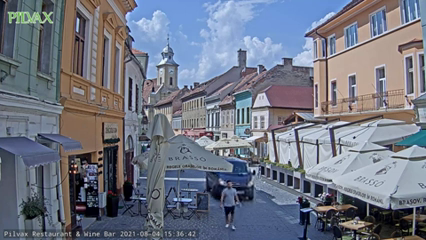

In [640]:
#_tmp4_crop.evaluate(_tmp4_video.evaluate()['image'])['image']

image = _tmp4_video.evaluate()['image']
#_tmp4_crop.fromNormalized(_tmp4_crop.flat(), size=image.size)
#_tmp4_crop.flat()
image

In [560]:
_tmp4_crop.__dict__

{'min': [0.45305164319248825, 0.6166666666666667],
 'max': [0.7018779342723005, 0.95],
 'size': None,
 'mode': 1}

In [ ]:
self.initMinMax(action.size,(0,0,action.size[0]-1,action.size[1]-1))

In [621]:
#_tmp4_crop.__dict__
#_tmp4_video.evaluate()
#_tmp4_video.__dict__
_tmp4_crop.action.__dict__

AttributeError: 'CropAction' object has no attribute 'action'

In [641]:
_tmp4_crop_widget = CropWidget(action=_tmp4_crop, videoAction=_tmp4_video ,parent=None)
display(_tmp4_crop_widget.vbox)

In [642]:
_tmp4_crop_widget.displayWidget = DisplayWidget(action=_tmp4_video,update=_tmp4_crop_widget.updateImage)
display(_tmp4_crop_widget.displayWidget.hbox)

In [643]:
#_tmp4_crop_widget.action.__dict__
#_tmp4_crop_widget.action.normalized()
#_tmp4_crop_widget.action.min
#_tmp4_crop_widget.action.crop(_tmp4_crop_widget.action._flat())
#_tmp4_crop_widget.action._flat(), _tmp4_crop_widget.action.__dict__
#_tmp4_crop.__dict__
#_tmp4_crop.flat()
#_tmp4_crop.toWorld(image.size).__dict__
#_tmp4_crop_widget.action.__dict__


{'min': [115, 88], 'max': [179, 136], 'size': (256, 144), 'mode': 0}

In [592]:
#_tmp4_video.__dict__
#_tmp4_crop_widget.displayWidget.on_next_image_button_clicked('')

#action.update(size)

_tmp4_crop_widget.action.__dict__
_size = _tmp4_crop_widget.displayWidget.image.size
#_tmp4_crop_widget.action.update(_size)

_tmp4_crop_widget.action.mode == _tmp4_crop_widget.action.WORLD

_tmp4_crop_widget.action.toWorld(size=_size).__dict__

{'min': [115, 88], 'max': [179, 136], 'size': None, 'mode': 0}

In [577]:
#_tmp4_video.evaluate()['image']
image = _tmp4_crop_widget.displayWidget.image
#_tmp4_crop_widget.updateImage(_tmp4_crop_widget.displayWidget.image)

#_tmp4_crop_widget.action.fromNormalized(_tmp4_crop_widget.action.flat(), size=image.size)
#_tmp4_crop_widget.action.__dict__, _tmp4_crop.__dict__
#_tmp4_crop_widget.action.__dict__, _tmp4_crop_widget.action.fromNormalized(_tmp4_crop_widget.action.flat(), size=image.size).__dict__
image

In [574]:
_tmp4_crop_widget.action.__dict__, _tmp4_crop.__dict__

In [ ]:
if isinstance(_tmp.dict(), dict):
    print('dict')


#EasyVideoPipeLine().from_dict(_tmp.dict()).sources.videos

_tmp3 = EasyVideoPipeLine().from_dict(_tmp.dict())
_tmp3.actions[0].init(sources=_tmp3.sources)
_action0 = _tmp3.actions[0]
_action0.setIndex(2)
_imageWidget2 = ImageWidget(display=True)

In [ ]:
_action0.setIndex(1)

In [ ]:
_action0.skipFrames(15)
_tmp3.actions[0].evaluate()['image']
_imageWidget2.setImage(_tmp3.actions[0].evaluate())

In [ ]:
_action1 = _tmp3.actions[1]
_action2 = _tmp3.actions[2]

_action2.algorithm = Image.LANCZOS

#_action2.evaluate(_action1.evaluate(_imageWidget2.getImage())['image'])['image']

_imageWidget2.setImage(_action1.evaluate(_imageWidget2.getImage())['image'])

#_action2.dict()

In [ ]:
#_tmp3.actions[2].algorithm = Image.LANCZOS
_tmp3.actions[2].__dict__
_tmp3.actions[0].setIndex(5)
_tmp3.actions[0].skipframes = 60

In [ ]:
_tmp3.actions[0].__dict__

In [ ]:
# set result to imagewidget
_imageWidget2.evaluate(**  evaluateActionList(_tmp3.actions, {}))

In [ ]:
_actions = [ResizeAction(size=(900,500))]
evaluateActionList(_actions, {'image':_action.readImage()})['image']

In [ ]:
#_action.sources.videos[_action.id]
_action.video

In [ ]:
_videoSources.sources.videos[list(_videoSources.sources.videos.keys())[1]]

In [ ]:
_action.evaluate()['image']

In [ ]:
CropAction(min=(0,0),max=(480,640),size=(1920,1080),mode=CropAction.WORLD).dict(), CropAction(min=(0,0),max=(480,640),size=(1920,1080),mode=CropAction.WORLD).toNormalized().__dict__

# FileVideoStream

In [ ]:
# import the necessary packages
from threading import Thread
import sys
import cv2
# import the Queue class from Python 3
from queue import Queue

class FileVideoStream:
    def __init__(self, queueSize=128, action=None):
        # initialize the file video stream along with the boolean
        # used to indicate if the thread should be stopped or not
        #_entry = videos[name]
        #_video  = pafy.new(_entry['url'])
        #self.stream = _video.streams[index]
        #self.capture = cv2.VideoCapture(self.stream.url)
        self.action = action
        self.stopped = False
        # initialize the queue used to store frames read from
        # the video file
        self.Q = Queue(maxsize=queueSize)
        
    def start(self):
        # start a thread to read frames from the file video stream
        t = Thread(target=self.update, args=(), name="FileVideoStream")
        t.daemon = True
        t.start()
        return self      
    
    def update(self):
        # keep looping infinitely
        while True:
            # if the thread indicator variable is set, stop the
            # thread
            if self.stopped:
                return
            # otherwise, ensure the queue has room in it
            if not self.Q.full():
                # read the next frame from the file
                #(grabbed, frame) = self.capture.read()
                # if the `grabbed` boolean is `False`, then we have
                # reached the end of the video file
                #frame = self.action.readImage()
                frame = self.action.evaluate()
                grabbed = True
                if not grabbed:
                    self.stop()
                    return
                # add the frame to the queue
                self.Q.put(frame)    
                
    def evaluate(self):
        # return next frame in the queue
        return self.Q.get()
    
    def more(self):
        # return True if there are still frames in the queue
        return self.Q.qsize() > 0
    
    def stop(self):
        # indicate that the thread should be stopped
        self.stopped = True

In [ ]:
_action.skipframes=15
fs = FileVideoStream(queueSize=60,action=_action).start()

In [ ]:
frame = fs.read() 
frame
#_imagew.setImage(frame)

In [ ]:
#_action_dict_list
_caction.dict()

In [ ]:
#_action.skipframes=10

_caction = createActionOfDict(_crop.action.toNormalized().dict())

while True:      
        try:
            frame = fs.read()
            _imagew.setImage(_caction.evaluate(image=frame['image'])['image'])
        except Exception as exception:
            print('done', str(exception))

In [ ]:
_vaction = _crop.videoAction

In [ ]:
_imagew = ImageWidget()

In [ ]:
#while fs.more():
from imutils.video import FPS
fps = FPS().start()

while True:    
    frame = fs.read()
    cv2.putText(frame, "Queue Size: {}".format(fs.Q.qsize()),
        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    _img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    _img = evaluateActionDictList(_action_dict_list,_img)
    #_imagew.setImage(_img)
    fps.update()
    print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

In [ ]:
fs.stop()

In [ ]:
fps.stop()
#print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
#print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# VideoLoopPlayer

In [ ]:
#from queue import Queue

_action=_crop.videoAction
_action.skipframes = 60
_images = _action.readImages(40)

In [ ]:
#_images[30]
#_action.skipframes


In [ ]:
#imageWidget.setImage(_loop.evaluate()['image'])

In [ ]:
class VideoLoopAction():
    def __init__(self,images=None):
        self.index  = 0
        self.step   = 1
        self.images = images
        
    def evaluate(self):
        self.index = self.index + self.step
        if self.index > len(self.images) - 1:
            self.index = 0
    
        return {'image':self.images[self.index]}  

In [ ]:
import ipywidgets as widgets
style = {'description_width': '250px'}
layout = {'width': '500px'}

#_caction = createActionOfDict(_crop.action.toNormalized().dict())
#_vaction = fs

def on_next_button_clicked1(b):  
    #newvalue = int(frame.value) + 1
    #if newvalue == len(imgs):
    #    newvalue = 0
    #frame.value =  str(newvalue)
    #imageWidget.setImage(CropAction(**para_dict).evaluate(image=imgs[newvalue]))
    #imageWidget.setImage(_action.evaluate(image=imgs[newvalue]))
    #_img = capture.getFrame()
    #_img = imgs[newvalue]
    #_img = _vaction.readImageOfStream()
    #frame1 = fs.read()
    #_img = Image.fromarray(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
    #_img = evaluateActionDictList(_action_dict_list,_img)
    #imageWidget.setImage(_img)
    frame = fs.read()
    _imagew.setImage(_caction.evaluate(image=frame['image'])['image']) 

def on_next_button_clicked(b):  
    #_img = _vaction.readImageOfStream()
    
    pass
    #_caction = _crop.action.toNormalized()
    #frame = _vaction.evaluate()
    #_img = _caction.evaluate(image=frame['image'])['image']
    #imageWidget.setImage(_img)
    
def initBufferedStream():    
    name='_hEh5wF6lxE'
    _entry = videos[name]
    _video  = pafy.new(_entry['url'])
    fs.stream = _video.streams[int(stream.value)]
    fs.capture = cv2.VideoCapture(fs.stream.url)
    
def on_download_button_clicked(b):  
    global imgs
    next_button.disabled = True
    #imgs = readImagesOfStream(video.streams[int(stream.value)],int(numberframes.value),skipframes=int(skipframes.value))
    #imgs = capture.readFrames(int(numberframes.value),skipframes=int(skipframes.value))
    global _vaction
    _vaction = VideoAction(video,index=int(stream.value),skipframes=int(skipframes.value))
    
    #initBufferedStream()
    
    frame.value = '0'
    next_button.disabled = False

def on_value_change_loop(b):
    if b['new'] == True:
        exe = HaltableExecutor(loop,sleep)
        exe.start()
        pending = asyncio.all_tasks()
        print(pending)
    else:
        for task in asyncio.all_tasks(): 
            if task.get_name() == 'test': 
                task.cancel()

    
stream     = widgets.Text(description   = 'stream',value = '1', style=style, layout=layout)
numberframes = widgets.Text(description = 'number frames',value = '10', style=style, layout=layout)
skipframes = widgets.Text(description   = 'skip frames',value = '10', style=style, layout=layout)
frame = widgets.Text(description = 'frame',value = '0', style=style, layout=layout)
sleep = widgets.Text(description = 'sleep',value = '0.0', style=style, layout=layout)
loop = widgets.Checkbox(description='loop',value=False)
#loop.observe(on_value_change_loop)    
download_button = widgets.Button(description='download', disabled=False, tooltip='resize',style=style, layout=layout)
download_button.on_click(on_download_button_clicked)  
next_button = widgets.Button(description='next', disabled=False, tooltip='resize',style=style, layout=layout)
next_button.on_click(on_next_button_clicked)  
vbox = widgets.VBox([stream,numberframes,skipframes,download_button,frame,sleep,loop,next_button])
display(vbox)
imageWidget=ImageWidget()
#imageWidget.display()

In [ ]:
#imageWidget.getImage().size
#video.streams
#VideoAction.__dict__

#_vaction.skipframes = 60

#display(DisplayWidget(action=_loop,imageWidget=imageWidget).hbox)
_loop = VideoLoopAction(images=_images)
display(DisplayWidget0(action=_loop,imageWidget=imageWidget).hbox)

In [ ]:
imageWidget.setImage(_loop.evaluate())

In [ ]:
import ipywidgets as widgets
import asyncio
import time

class HaltableExecutor:

    def __init__(self, checkbox,imageWidget,sleep,action):
        self._checkbox = checkbox
        self.imageWidget = imageWidget
        self._sleep    = sleep
        self.action  = action
        
    async def my_code(self):
        # This is your user code
        while True:
            if self._checkbox.value:
                print('running')  # put your code here
                #self.function('b')
                #self.imageWidget.setImage(self.action.evaluate())
                time.sleep(float(self._sleep.value))
            await asyncio.sleep(0.1)  # use this to temporarily give up control of the event loop to allow scheduling checkbox changes
    
    def start(self):
        print('starting')
        #asyncio.current_task().foo = "Bar"
        #asyncio.current_task().name = "#{}".format(n)
        task = asyncio.ensure_future(self.my_code())
        task.set_name('test')
        #asyncio.current_task().name = 'test'
        
#c = widgets.Checkbox(description='click me',value=False)
#display(c)        


exe = HaltableExecutor(_run,imageWidget,0,_loop)
exe.start()


In [ ]:
_loop.index, _loop.step
#imageWidget.display()
_run = widgets.Checkbox(description='loop',value=False)
imageWidget=ImageWidget()
display(_run)

In [ ]:
import ipywidgets as widgets
import asyncio
import time

class HaltableExecutor:

    def __init__(self, checkbox=checkbox,sleep=sleep,class=None,function=evaluate,imageWidget=imageWidget):
        self._checkbox = checkbox
        self.imageWidget = imageWidget
        self._sleep    = sleep
        self.class     = class
        self.function  = function
        
    async def my_code(self):
        # This is your user code
        while True:
            if self._checkbox.value:
                #print('running')  # put your code here
                #self.function('b')
                self.imageWidget.setImage(self.claas.function
                time.sleep(float(self._sleep.value))
            await asyncio.sleep(0.1)  # use this to temporarily give up control of the event loop to allow scheduling checkbox changes
    
    def start(self):
        print('starting')
        #asyncio.current_task().foo = "Bar"
        #asyncio.current_task().name = "#{}".format(n)
        task = asyncio.ensure_future(self.my_code())
        task.set_name('test')
        #asyncio.current_task().name = 'test'
        
#c = widgets.Checkbox(description='click me',value=False)
#display(c)        

#exe = HaltableExecutor(loop,sleep,on_next_button_clicked)
exe = HaltableExecutor(checkbox=_run,sleep=sleep,class=_loop,imageWidget=imageWidget)
exe.start()

In [ ]:
def deleteAllTasks(name):
    for task in asyncio.all_tasks(): 
                if task.get_name() == name: 
                    task.cancel()
                
pending = asyncio.all_tasks()
#next(iter(pending)).cancel()
len(pending)
#pending
#asyncio.current_task().set_name('test')
#next(iter(pending)).get_name()
#task, = [task for task in asyncio.all_tasks() if task.get_name() == 'test']
#task.get_name()
#deleteAllTasks('test')
pending
deleteAllTasks('test')

In [ ]:
asyncio.all_tasks()

# Contrast

In [68]:
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)

#constant by which each pixel is divided
def change_brightness(im,constant=0.31):
    source = im.split()
    R, G, B = 0, 1, 2
    Red = source[R].point(lambda i: i/constant)
    Green = source[G].point(lambda i: i/constant)
    Blue = source[B].point(lambda i: i/constant)
    im = Image.merge(im.mode, (Red, Green, Blue))
    im.save('modified-image.jpeg', 'JPEG', quality=100)
    return im

def getByteArray(image):    
    img_byte_arr = io.BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()
    return img_byte_arr

def enhance_image(im, contrast=0, brightness=1.0):
    im = change_contrast(im, contrast)
    im = change_brightness(im, brightness)
    return im
 
# widgets   
import ipywidgets as widgets    
def on_value_change_enhance(change):
    im = enhance_image(_image, contrast=contrast_w.value, brightness=brightness_w.value)
    results_w.value = str(int(1))
    image_w2.value = getByteArray(im)

layout = {'width': '500px'}
style = {'description_width': '50px'}
contrast_w    = widgets.IntSlider(value=0,description='contrast', min=-1000, max=1000, step=1,layout=layout)
brightness_w  = widgets.FloatSlider(value=1.0,description='brightness', min=0, max=1.0, step=0.001, readout_format='.3f',layout=layout)
results_w = widgets.Text(description='results',value = '0', style=style, layout=layout)
image_w2      = widgets.Image(format='PNG')
contrast_w.observe(on_value_change_enhance,'value')
brightness_w.observe(on_value_change_enhance,'value')
display(contrast_w,brightness_w,results_w,image_w2)

# _image = <Bild, das verändert werden soll>
_image = _crop.image

IntSlider(value=0, description='contrast', layout=Layout(width='500px'), max=1000, min=-1000)

FloatSlider(value=1.0, description='brightness', layout=Layout(width='500px'), max=1.0, readout_format='.3f', …

Text(value='0', description='results', layout=Layout(width='500px'), style=DescriptionStyle(description_width=…

Image(value=b'', format='PNG')

AttributeError: 'CropWidget' object has no attribute 'image'

# trial

In [ ]:
import requests
response = requests.get(_videoSources.video.thumb)

img_byte_arr = io.BytesIO(response.content).read()
_imagew.image_w.value = img_byte_arr

In [ ]:
_videoSources.video.thumb

# tab

In [178]:
#!/usr/bin/env python

from Tkinter import *
import tkMessageBox
import ttk

#---------------------------------------------------------------------
class MyTab(Frame):

    def __init__(self, root, name):
        Frame.__init__(self, root)

        self.root = root
        self.name = name

        self.entry = Entry(self)
        self.entry.pack(side=TOP)

        self.entry.bind('<FocusOut>', self.alert)
        self.entry.bind('<Key>', self.printing)

        self.bind("<Button-1>", self.clickFrame)

    #-------------------------------

    def alert(self, event):
        print 'FocusOut event is working for ' + self.name + '  value: ' + self.entry.get()
        #tkMessageBox.showinfo('alert', 'FocusOut event is working for ' + self.name + '  value: ' + self.entry.get())

    #-------------------------------

    def printing(self, event):
        print event.keysym + ' for ' + self.name

    #-------------------------------

    def clickFrame(self, event):
        print "MyTab: click at (" + str(event.x) + ", " + str(event.y) + ') for ' + self.name + " (parent name: " + self.root.tab(CURRENT)['text'] + ")"


#---------------------------------------------------------------------

class Application():

    def __init__(self):

        self.tabs = {'ky':1} 

        self.root = Tk()
        self.root.minsize(300, 300)
        self.root.geometry("1000x700")

        self.notebook = ttk.Notebook(self.root, width=1000, height=650)

#       self.all_tabs = []

        self.addTab('tab1')

        self.button = Button(self.root, text='generate', command=self.start_generating).pack(side=BOTTOM)

        self.notebook.pack(side=TOP)

    #-------------------------------

    def addTab(self, name):
        tab = MyTab(self.notebook, name)
        tab.bind("<Button-3>", self.clickTab)
        self.notebook.add(tab, text="X-"+name)
#       self.all_tabs.append(tab)

    #-------------------------------

    def clickTab(self, event):
        print "Application: click at (" + str(event.x) + ", " + str(event.y) + ') for ' + event.widget.name

        #-------------------------------

    def start_generating(self):
        if self.tabs['ky'] < 4:
            self.tabs['ky'] += 1
            self.addTab('tab'+ str(self.tabs['ky'])) 

    #-------------------------------

    def run(self):
        self.root.mainloop()

#----------------------------------------------------------------------

Application().run()     

SyntaxError: invalid syntax (<ipython-input-178-6b2a080f68ae>, line 27)